Virual env: myenv

# Importings

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import ast
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import transformers
from transformers.modeling_bert import BertForTokenClassification
from transformers.optimization import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score
from tqdm import trange 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score,classification_report,f1_score, accuracy_score, precision_score


In [21]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(n_gpu)

In [4]:
def FindMaxLength(lst):
    maxList = max(lst, key = lambda i: len(i))
    maxLength = len(maxList)
     
    return maxLength

In [5]:
df = pd.read_csv('./uspto_1_desc_final.csv')
sentences = df['segments'].to_list()
sentences = [ast.literal_eval(x) for x in sentences]
labels = df[' segments_binary'].to_list()
labels = [ast.literal_eval(x) for x in labels]

In [6]:
df

,Unnamed: 0,Unnamed: 0.1,grant_id,description_text,segments,segments_binary
0,0,0,USD0961886,========== \n\n\n \n ========== \n 1. Candy \...,"[' 1. Candy ', ' 1.11.21.31.41.51.61.7 ', ' Th...","[0, 1, 0, 0]"
1,1,1,USD0961887,========== \n\n\nFIG. 1FIG. 2FIG. 3FIG. 4FIG....,['FIG. 1FIG. 2FIG. 3FIG. 4FIG. 5FIG. 6FIG. 7FI...,"[1, 0, 0]"
2,2,2,USD0961888,========== \n\n\nFIG. 1FIG. 2FIG. 3FIG. 4FIG....,['FIG. 1FIG. 2FIG. 3FIG. 4FIG. 5FIG. 6FIG. 7FI...,"[1, 0, 0]"
3,3,3,USD0961889,========== \n\n\nFIG. 1FIG. 2FIG. 1FIG. 3FIG....,['FIG. 1FIG. 2FIG. 1FIG. 3FIG. 1FIG. 4FIG. 1FI...,"[1, 0, 1, 0, 1, 0, 1, 0, 0]"
4,4,4,USD0961890,========== \n\n\nFIG. 1FIG. 2FIG. 3FIG. 4FIG....,['FIG. 1FIG. 2FIG. 3FIG. 4FIG. 5FIG. 6FIG. 7FI...,[0]
...,...,...,...,...,...,...
7257,7257,7257,US11432447,========== \n\n \n ========== \n BACKGROUND O...,"[' BACKGROUND OF THE INVENTION ', ' Field of t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7258,7258,7258,US11432448,========== \n\n \n ========== \n CROSS-REFERE...,"[' CROSS-REFERENCE TO RELATED APPLICATIONS ', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7259,7259,7259,US11432449,========== \n\n \n ========== \n CROSS-REFERE...,"[' CROSS-REFERENCE TO RELATED APPLICATIONS ', ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7260,7260,7260,US11432450,========== \n\n \n ========== \n TECHNICAL FI...,"[' TECHNICAL FIELD ', ' The present disclosure...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [33]:
tag_values = [0,1]
tag_values.append(2)
tag2idx = {t: i for i, t in enumerate(tag_values)}
n_tags = len(tag_values)
MAX_LEN = 512
bs = 16

# Description of the model
Our model is a pre-trained BERT
- Input:
X = an array of sentences where a sentence is a list of description text segments.
- Output:
y = an array of tags where a tag is a list containing binary values for each element in the sequence

- The tokenizer is based on a word-piece tokenizer that tokenizes the sentence to words that appear in the vocabulary.

In [34]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx[2], padding="post",
                     dtype="long", truncating="post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.3)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.3)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [35]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


In [36]:
model.cuda();


In [37]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [38]:
epochs = 1
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [39]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    #Training
    
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        # forward pass
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    #Validation
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
            
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))



Epoch:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]

Average train loss: 0.06593092129288732
Validation loss: 0.01042973922132114


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [12:12<00:00, 732.75s/it]

Validation Accuracy: 0.9137021712941716



In [40]:
print('epochs =',epochs,'|', 'batch_size=', bs, '|', 'optimizer: ',optimizer,'|', 'loss:', loss, '\n')
print('recall_score', recall_score(valid_tags, pred_tags, average='macro', labels=np.unique(pred_tags)))
print('f1_score',f1_score(valid_tags, pred_tags, average='macro', labels=np.unique(pred_tags)))
print('accuracy_score',accuracy_score(valid_tags, pred_tags))
print('precision_score',precision_score(valid_tags, pred_tags, average='macro'))

epochs = 1 | batch_size= 1 | optimizer:  AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 3e-05
    lr: 0.0
    weight_decay: 0.0
    weight_decay_rate: 0.01

Parameter Group 1
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    initial_lr: 3e-05
    lr: 0.0
    weight_decay: 0.0
    weight_decay_rate: 0.0
) | loss: tensor(4.6075e-05, device='cuda:0', grad_fn=<NllLossBackward>) 

recall_score 0.9954360206811561
f1_score 0.6416116523937907
accuracy_score 0.9137021712941716
precision_score 0.38299831205506485


/home/smidab/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


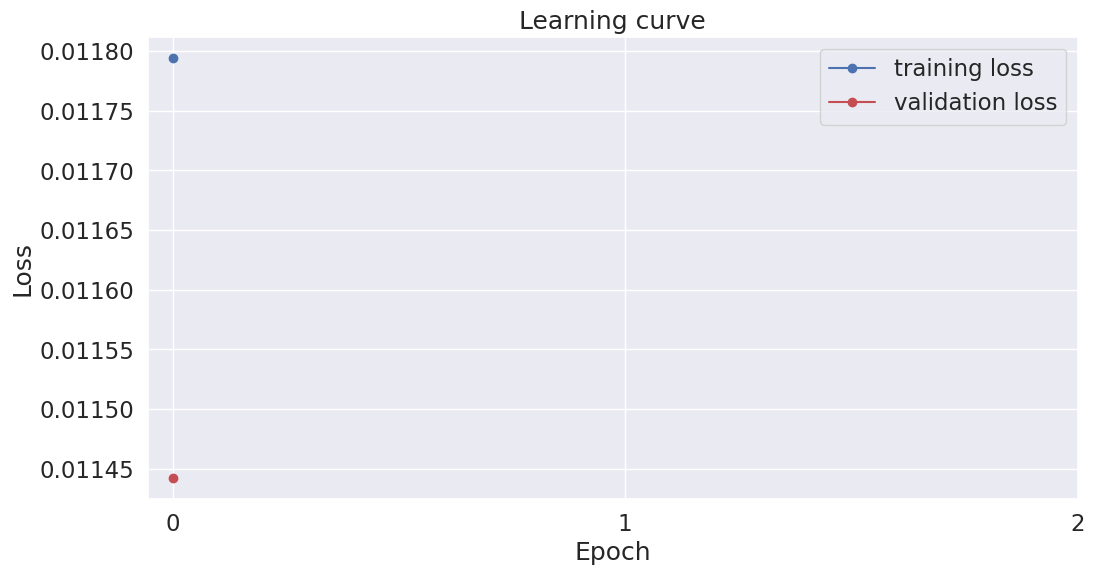

In [32]:
%matplotlib inline



# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.xticks([0, 1, 2])
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
